In [1]:
import numpy as np
import sys
import datetime
import h5py as h5
import matplotlib.pyplot as plt
from pathlib import Path
import psana as ps
from importlib import reload

import svd_waveform_processing as proc
import make_waveform_basis

sys.path.append('/reg/neh/home/espov/python/smalldata_tools/') # path to smalldata_tools
import smalldata_tools.DetObject as dobj

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=14)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

In [3]:
exp_name = 'xcsx35017'
run = 112
# det_name = 'GMD_ACQ_RAW'
det_name = 'acq01'
nevt_max = 200
b = 50
n_c = 5
roi = [1350,1800]
# roi = None

hutch = exp_name[:3]
savePath = Path('/reg/d/psdm/{}/{}/calib'.format(hutch, exp_name))

dstr = 'exp={}:run={}'.format(exp_name, run)
print('\n'+dstr+'\n')


exp=xcsx35017:run=112



# Test function to make basis

In [4]:
reload(make_waveform_basis)
fbasis = make_waveform_basis.make_basis(exp_name, run, det_name, nWaveforms=nevt_max, b=b, n_c=n_c, roi=roi)


exp=xcsx35017:run=112

Getting the detector for:  acq01
wave_basis_acq01_20200810_121847.h5
Basis file saved as /reg/d/psdm/xcs/xcsx35017/calib/wave_basis_acq01_20200810_121847.h5.


In [5]:
print(fbasis)

/reg/d/psdm/xcs/xcsx35017/calib/wave_basis_acq01_20200810_121847.h5


# Check basis file

In [6]:
f = h5.File(fbasis, 'r')
print('\n'.join(f.keys()))

A
background_index
components
projector
ref_waveforms
roi
singular_values


# Display basis vectors and eigenvalues

In [7]:
ds = ps.MPIDataSource(dstr)
det = dobj.DetObject(det_name, ds.env(), int(run))
ii=0
waveforms = []
for nevt,evt in enumerate(ds.events()):
    if ii>100:
        break

    try:
        det.getData(evt)
        wave = np.squeeze(det.evt.dat)
#             print(wave.shape)
    except:
        continue

    if b is not None:
        wave = wave - np.mean(wave[:b])
    if roi is not None:
        wave = wave[roi[0]:roi[1]]
    waveforms.append(wave)
    ii+=1

waveforms = np.asarray(waveforms)

A, proj, svd = proc.get_basis_and_projector(waveforms[:], n_components=n_c)

Getting the detector for:  acq01


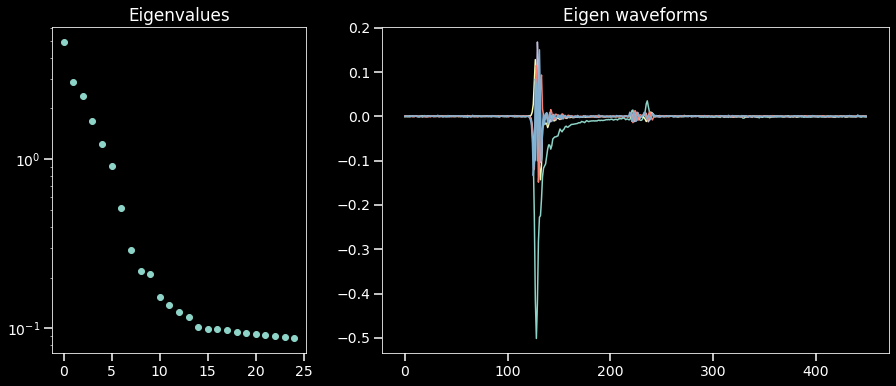

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,6), gridspec_kw={'width_ratios':[1,2]})
ax[0].set_title('Eigenvalues')
ax[0].plot(svd.singular_values_,'o')
ax[0].set_yscale('log')
ax[1].set_title('Eigen waveforms')
ax[1].plot(svd.components_[0])
ax[1].plot(0.3*svd.components_[1:5].T)
# ax[1].plot(0.3*svd.components_[2])
# ax[1].plot(0.3*svd.components_[3])
# ax[1].set_xlim(100,200)
plt.show()